In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
params = {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 1}


In [4]:
import numpy as np
from src.shared.json_tools import load_json_long
from paths import DATA_DIR

np.random.seed(42)  # for reproducibility
X = []
y = []

for file in (DATA_DIR / "selected").glob("*.json"):
    if len(X) >= 1000:
        break
    data = load_json_long(file)
    targets = [int(i["target"] >= 0.5) for i in data]
    features = [i["content"] for i in data]
    
    features = np.array(features)
    targets = np.array(targets)
    
    pos_indices = np.where(targets == 1)[0]
    neg_indices = np.where(targets == 0)[0]
    
    min_class_count = min(len(pos_indices), len(neg_indices))
    pos_sample = np.random.choice(pos_indices, min_class_count, replace=False)
    neg_sample = np.random.choice(neg_indices, min_class_count, replace=False)
    
    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)
    
    features_balanced = features[balanced_indices]
    y_balanced = targets[balanced_indices]
    
    X = X + features_balanced.tolist()
    y = y + y_balanced.tolist()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    print(confusion_matrix(y_true, y_pred))

In [8]:
from xgboost import XGBClassifier
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_gpu = torch.from_numpy(np.array(X_train)).to(device)
y_train_gpu = torch.from_numpy(np.array(y_train)).to(device)

X_test_gpu = torch.from_numpy(np.array(X_test)).to(device)

model = XGBClassifier(
    device="cuda",  # ensure both training and prediction use GPU
    eval_metric="logloss",
    random_state=42,
    **params
)

model.fit(X_train_gpu, y_train_gpu)

Using device: cuda


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
y_pred = model.predict(X_train_gpu)
evaluate(y_train, y_pred)

Accuracy: 0.9854641559299636
Precision: 0.9732375979112271
Recall: 0.9979919678714859
F1 Score: 0.985459352280238

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      1533
           1       0.97      1.00      0.99      1494

    accuracy                           0.99      3027
   macro avg       0.99      0.99      0.99      3027
weighted avg       0.99      0.99      0.99      3027

[[1492   41]
 [   3 1491]]


In [10]:
y_pred = model.predict(X_test_gpu)
evaluate(y_test, y_pred)

Accuracy: 0.8533685601056803
Precision: 0.8195991091314031
Recall: 0.9246231155778895
F1 Score: 0.8689492325855962

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83       359
           1       0.82      0.92      0.87       398

    accuracy                           0.85       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.86      0.85      0.85       757

[[278  81]
 [ 30 368]]


In [13]:
y_pred_prob = model.predict_proba(X_test_gpu)[:, 1]

In [14]:
y_pred_prob

array([9.23240364e-01, 1.42346129e-01, 1.75379515e-01, 6.78216338e-01,
       8.48945230e-03, 4.66256559e-01, 6.37748659e-01, 9.86443758e-01,
       4.01698232e-01, 3.90553917e-03, 4.21317257e-02, 3.99934733e-03,
       5.71594417e-01, 2.87316274e-02, 3.10760051e-01, 7.34266579e-01,
       9.91695583e-01, 9.38223541e-01, 6.90372944e-01, 1.58686377e-02,
       9.98350024e-01, 3.54010990e-04, 8.97805035e-01, 7.16590285e-01,
       2.83551782e-01, 9.59775090e-01, 8.32980216e-01, 7.25324214e-01,
       1.70269802e-01, 1.21695166e-02, 3.15972662e-04, 9.44934309e-01,
       9.89302576e-01, 9.73274589e-01, 6.98396325e-01, 1.26540720e-01,
       8.34591861e-04, 8.37122858e-01, 9.65761900e-01, 8.13325524e-01,
       9.56515372e-01, 3.42806280e-01, 6.71298578e-02, 9.35630977e-01,
       1.57081738e-01, 9.61684883e-01, 9.96705711e-01, 5.44623256e-01,
       9.84813869e-01, 9.43915188e-01, 5.42695582e-01, 8.59036446e-01,
       3.88491690e-01, 8.14319253e-01, 9.56643641e-01, 8.01416207e-03,
      

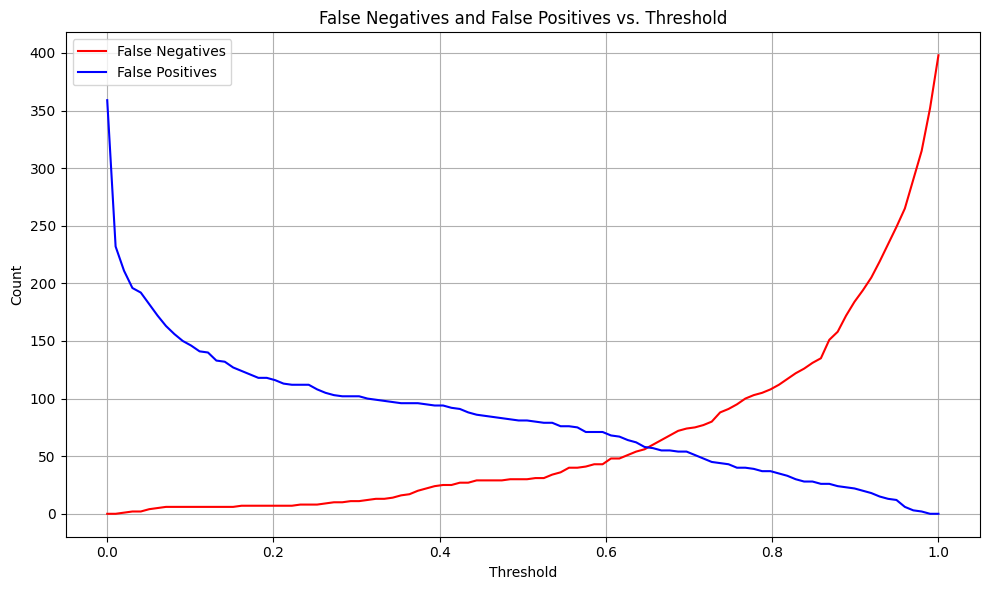

In [15]:
import matplotlib.pyplot as plt
y_pred_prob = model.predict_proba(X_test_gpu)[:, 1]

# Thresholds to evaluate
thresholds = np.linspace(0, 1, 100)
false_negatives = []
false_positives = []

# Calculate FN and FP for each threshold
for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_negatives.append(fn)
    false_positives.append(fp)

# Plotting both FN and FP
plt.figure(figsize=(10, 6))
plt.plot(thresholds, false_negatives, label='False Negatives', color='red')
plt.plot(thresholds, false_positives, label='False Positives', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('False Negatives and False Positives vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Save the model
import pickle
from paths import MODEL_DIR

model_path = MODEL_DIR / "xgboost_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)